In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import numpy as np
import matplotlib.pyplot as plt

Load Data

The purpose of the task is machine translatioin with transfomer (Non using any rnn or cnn)

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteR33F39/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteR33F39/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteR33F39/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [0]:
train_example, val_example = examples['train'], examples['validation']

In [4]:
# Checking loaded data

for n, i in enumerate(train_example.take(1)):
  print(i)
print('\n')
  # i <- (prtuguese, english)

for n, (pt, en) in enumerate(train_example.take(1)):
  print(pt)
  print()
  print(en)

  print('\nNumpy Format Below\n')
  print(pt.numpy())
  print()
  print(en.numpy())

(<tf.Tensor: shape=(), dtype=string, numpy=b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'>, <tf.Tensor: shape=(), dtype=string, numpy=b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'>)


tf.Tensor(b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .', shape=(), dtype=string)

tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string)

Numpy Format Below

b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'

b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'


In [0]:
# Create Tokenizer with tfds word peice
 
 tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_example), 
                                                                        target_vocab_size=2**13)
 
 tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for pt, en in train_example), 
                                                                        target_vocab_size=2**13)

In [6]:
# Testing tokenizer encode and decode

sample_string = 'becarefull the covid 19'

tokenized_string = tokenizer_en.encode(sample_string)
print('Tokenized string : {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print('Reverted string : {}'.format(original_string))


# Check how the each word converted
for word in tokenized_string:
  print('{} -> {}'.format(word, tokenizer_en.decode([word])))

Tokenized string : [370, 3509, 246, 3, 759, 1259, 49, 1291]
Reverted string : becarefull the covid 19
370 -> be
3509 -> careful
246 -> l 
3 -> the 
759 -> co
1259 -> vi
49 -> d 
1291 -> 19


In [0]:
# Set the Hyperparam for data pipeline
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [0]:
# Add SOS & EOS
# SOS token = tokenizer.vocab_size      <- number
# EOS token = tokenizer.vocab_size + 1  <- number
def encode(lang1, lang2):
  '''
  lang1 = pt
  lang2 = en
  '''
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size + 1]
  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size + 1]
  return lang1, lang2

In [0]:
# To use the tf data format, convert python function to tf function

def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])
  return result_pt, result_en

In [0]:
# To reduce the training time, reduce its length below 40

MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length, 
                        tf.size(y) <= max_length)

In [0]:
# Preprocessed

train_preprocessed = train_example.map(tf_encode).filter(filter_max_length).cache().shuffle(BUFFER_SIZE)

val_preprocessed = val_example.map(tf_encode).filter(filter_max_length)

In [0]:
# Pad the string for each element has the same length

train_dataset = train_preprocessed.padded_batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_preprocessed.padded_batch(BATCH_SIZE)

In [13]:
# Check the data

pt_batch, en_batch = next(iter(val_dataset))

pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## Important

### Positional Encoding

The transfomer does not use any rnn or cnn, so it requires to add a positional information to the data


- The paper used "sin & cos encoding"
$${k} = {2i}$$
$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
----------
$${k} = {2i + 1}$$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

by following the fomula,

- pos refers length of the sequence
- d_model refers embedding dimention
- ${2i}$ refers time-step or index of the sequence

In [0]:
def get_angles_test(pos, i, d_model):
  # angle_rate = 1/1000^(2i/d_model)
  print('Pos: \n',pos)
  print('I: \n', i)
  print('I//2 \n', i//2)
  print('D_Model: \n',d_model)
  angle_rate = 1 / np.power(10000, (2 * (i // 2) / np.float32(d_model)))
  print('Angle Rate: \n', angle_rate)
  
  return pos * angle_rate

In [0]:
def get_angles(pos, i, d_model):
  # angle_rate = 1/1000^(2i/d_model)
  angle_rate = 1 / np.power(10000, (2 * (i // 2) / np.float32(d_model)))

  
  return pos * angle_rate

In [0]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], # (seq_len, 1)
                          np.arange(d_model)[np.newaxis, :],  # (1, emb_dim)
                          d_model)                            # (emb_dim)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [17]:
get_angles_test(10, 4, 4)

Pos: 
 10
I: 
 4
I//2 
 2
D_Model: 
 4
Angle Rate: 
 0.0001


0.001

In [60]:
print('pos result shape', get_angles_test(np.arange(10)[:, np.newaxis], 
                                          np.arange(10)[np.newaxis, :], 
                                          10).shape)

get_angles_test(np.arange(10)[:, np.newaxis], 
           np.arange(10)[np.newaxis, :], 
           10)


# get_angles(np.arange(10)[:, np.newaxis], 
#            np.arange(4)[np.newaxis, :], 
#            4)[:, 0::2] 

Pos: 
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
I: 
 [[0 1 2 3 4 5 6 7 8 9]]
I//2 
 [[0 0 1 1 2 2 3 3 4 4]]
D_Model: 
 10
Angle Rate: 
 [[1.         1.         0.15848932 0.15848932 0.02511886 0.02511886
  0.00398107 0.00398107 0.00063096 0.00063096]]
pos result shape (10, 10)
Pos: 
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
I: 
 [[0 1 2 3 4 5 6 7 8 9]]
I//2 
 [[0 0 1 1 2 2 3 3 4 4]]
D_Model: 
 10
Angle Rate: 
 [[1.         1.         0.15848932 0.15848932 0.02511886 0.02511886
  0.00398107 0.00398107 0.00063096 0.00063096]]


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.        , 0.15848932, 0.15848932, 0.02511886,
        0.02511886, 0.00398107, 0.00398107, 0.00063096, 0.00063096],
       [2.        , 2.        , 0.31697864, 0.31697864, 0.05023773,
        0.05023773, 0.00796214, 0.00796214, 0.00126191, 0.00126191],
       [3.        , 3.        , 0.47546796, 0.47546796, 0.07535659,
        0.07535659, 0.01194322, 0.01194322, 0.00189287, 0.00189287],
       [4.        , 4.        , 0.63395728, 0.63395728, 0.10047546,
        0.10047546, 0.01592429, 0.01592429, 0.00252383, 0.00252383],
       [5.        , 5.        , 0.7924466 , 0.7924466 , 0.12559432,
        0.12559432, 0.01990536, 0.01990536, 0.00315479, 0.00315479],
       [6.        , 6.        , 0.95093592, 0.95093592, 0.15071319,
        0.15071319, 0.02388643, 0.02388643, 0.00378574, 0.00378574],
       [7.        , 7.        , 1.1094252

In [62]:
tmp_pos = positional_encoding(50, 128)

tmp_pos.shape

TensorShape([1, 50, 128])

In [0]:
# Masking
# - Mask all the pad tokens in the batch of sequence

def create_padding_mask(seq):
  seq = tf.math.equal(seq, 0)
  seq = tf.cast(seq, tf.float32) # seq = (b, seq_len)
  return seq[:, tf.newaxis, tf.newaxis, :] # return (b, 1, 1, seq_len)

In [20]:
x = tf.constant([[7,6,0,0,0],
                 [1,2,3,0,0],
                 [0,0,0,4,5]])

create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 1.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [0]:
# Create Look-ahead-mask 
# It is for the futre tokens in a sequence
# the maks indicates which entries should not be used
# When predict the 3rd words, only use the 1st and 2nd words

# For example, 
# [1,2,3,4,5,6]
# when predicting 4, use only 1,2,3,  Not 4, 5, 6
# So the mask should be [1,1,1,0,0,0]
# To set the mask has a role for define where "NOT" to use, the mask seq should be [0,0,0,1,1,1]


def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [22]:
x = tf.random.uniform((1,3))

temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Model Architectures

### 1) Scaled - Dot product Attention


https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms

https://medium.com/@bgg/seq2seq-pay-attention-to-self-attention-part-2-cf81bf32c73d

Requires to Check 

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  # add mask to the attention weight
  
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
  output = tf.matmul(attention_weights, v)
  return output, attention_weights

In [116]:
-1e9

-1000000000.0

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

## Scaled Dot Attention

if the query is align with which value,
by following the attention weight, the values are avaraged.

In [0]:
def scaled_dot_product_attention_temp(q, k, v, mask):
  print('q', q)
  print('k', k)
  print('v', v)
  matmul_qk = tf.matmul(q, k, transpose_b=True)
  print('Matmul QK', matmul_qk)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  print('D_k', dk)

  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  print('QK / sqrt(d_k)', scaled_attention_logits)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  # add mask to the attention weight
    print('Masked Logits', scaled_attention_logits)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
  print('Attention Weights', attention_weights)

  output = tf.matmul(attention_weights, v)
  return output, attention_weights

In [0]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention_temp(q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

def print_out_mask(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention_temp(q, k, v, True)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [161]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

print_out(temp_q, temp_k, temp_v)

q tf.Tensor([[ 0. 10.  0.]], shape=(1, 3), dtype=float32)
k tf.Tensor(
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]
 [ 0.  0. 10.]], shape=(4, 3), dtype=float32)
v tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)
Matmul QK tf.Tensor([[  0. 100.   0.   0.]], shape=(1, 4), dtype=float32)
D_k tf.Tensor(3.0, shape=(), dtype=float32)
QK / sqrt(d_k) tf.Tensor([[ 0.       57.735027  0.        0.      ]], shape=(1, 4), dtype=float32)
Attention Weights tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [162]:
tf.transpose(temp_k)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[10.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.],
       [ 0.,  0., 10., 10.]], dtype=float32)>

In [163]:
tf.matmul(temp_q, tf.transpose(temp_k))

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[  0., 100.,   0.,   0.]], dtype=float32)>

In [164]:
print_out_mask(temp_q, temp_k, temp_v)

q tf.Tensor([[ 0. 10.  0.]], shape=(1, 3), dtype=float32)
k tf.Tensor(
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]
 [ 0.  0. 10.]], shape=(4, 3), dtype=float32)
v tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)
Matmul QK tf.Tensor([[  0. 100.   0.   0.]], shape=(1, 4), dtype=float32)
D_k tf.Tensor(3.0, shape=(), dtype=float32)
QK / sqrt(d_k) tf.Tensor([[ 0.       57.735027  0.        0.      ]], shape=(1, 4), dtype=float32)
Masked Logits tf.Tensor([[-1.0000000e+09 -9.9999994e+08 -1.0000000e+09 -1.0000000e+09]], shape=(1, 4), dtype=float32)
Attention Weights tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [165]:
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

q tf.Tensor([[10. 10.  0.]], shape=(1, 3), dtype=float32)
k tf.Tensor(
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]
 [ 0.  0. 10.]], shape=(4, 3), dtype=float32)
v tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)
Matmul QK tf.Tensor([[100. 100.   0.   0.]], shape=(1, 4), dtype=float32)
D_k tf.Tensor(3.0, shape=(), dtype=float32)
QK / sqrt(d_k) tf.Tensor([[57.735027 57.735027  0.        0.      ]], shape=(1, 4), dtype=float32)
Attention Weights tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [166]:
print_out_mask(temp_q, temp_k, temp_v)

q tf.Tensor([[10. 10.  0.]], shape=(1, 3), dtype=float32)
k tf.Tensor(
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]
 [ 0.  0. 10.]], shape=(4, 3), dtype=float32)
v tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)
Matmul QK tf.Tensor([[100. 100.   0.   0.]], shape=(1, 4), dtype=float32)
D_k tf.Tensor(3.0, shape=(), dtype=float32)
QK / sqrt(d_k) tf.Tensor([[57.735027 57.735027  0.        0.      ]], shape=(1, 4), dtype=float32)
Masked Logits tf.Tensor([[-9.9999994e+08 -9.9999994e+08 -1.0000000e+09 -1.0000000e+09]], shape=(1, 4), dtype=float32)
Attention Weights tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [167]:
temp_q = tf.constant([[0, 0, 10], 
                      [0, 10, 0], 
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
                      
print_out(temp_q, temp_k, temp_v)

q tf.Tensor(
[[ 0.  0. 10.]
 [ 0. 10.  0.]
 [10. 10.  0.]], shape=(3, 3), dtype=float32)
k tf.Tensor(
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]
 [ 0.  0. 10.]], shape=(4, 3), dtype=float32)
v tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)
Matmul QK tf.Tensor(
[[  0.   0. 100. 100.]
 [  0. 100.   0.   0.]
 [100. 100.   0.   0.]], shape=(3, 4), dtype=float32)
D_k tf.Tensor(3.0, shape=(), dtype=float32)
QK / sqrt(d_k) tf.Tensor(
[[ 0.        0.       57.735027 57.735027]
 [ 0.       57.735027  0.        0.      ]
 [57.735027 57.735027  0.        0.      ]], shape=(3, 4), dtype=float32)
Attention Weights tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [168]:
print_out_mask(temp_q, temp_k, temp_v)

q tf.Tensor(
[[ 0.  0. 10.]
 [ 0. 10.  0.]
 [10. 10.  0.]], shape=(3, 3), dtype=float32)
k tf.Tensor(
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]
 [ 0.  0. 10.]], shape=(4, 3), dtype=float32)
v tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)
Matmul QK tf.Tensor(
[[  0.   0. 100. 100.]
 [  0. 100.   0.   0.]
 [100. 100.   0.   0.]], shape=(3, 4), dtype=float32)
D_k tf.Tensor(3.0, shape=(), dtype=float32)
QK / sqrt(d_k) tf.Tensor(
[[ 0.        0.       57.735027 57.735027]
 [ 0.       57.735027  0.        0.      ]
 [57.735027 57.735027  0.        0.      ]], shape=(3, 4), dtype=float32)
Masked Logits tf.Tensor(
[[-1.0000000e+09 -1.0000000e+09 -9.9999994e+08 -9.9999994e+08]
 [-1.0000000e+09 -9.9999994e+08 -1.0000000e+09 -1.0000000e+09]
 [-9.9999994e+08 -9.9999994e+08 -1.0000000e+09 -1.0000000e+09]], shape=(3, 4), dtype=float32)
Attention Weights tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype

In [169]:
temp_q = tf.constant([[0, 5, 10], 
                      [4, 10, 7], 
                      [10, 10, 9]], dtype=tf.float32)  # (3, 3)
                      
print_out(temp_q, temp_k, temp_v)

q tf.Tensor(
[[ 0.  5. 10.]
 [ 4. 10.  7.]
 [10. 10.  9.]], shape=(3, 3), dtype=float32)
k tf.Tensor(
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 10.]
 [ 0.  0. 10.]], shape=(4, 3), dtype=float32)
v tf.Tensor(
[[   1.    0.]
 [  10.    0.]
 [ 100.    5.]
 [1000.    6.]], shape=(4, 2), dtype=float32)
Matmul QK tf.Tensor(
[[  0.  50. 100. 100.]
 [ 40. 100.  70.  70.]
 [100. 100.  90.  90.]], shape=(3, 4), dtype=float32)
D_k tf.Tensor(3.0, shape=(), dtype=float32)
QK / sqrt(d_k) tf.Tensor(
[[ 0.       28.867514 57.735027 57.735027]
 [23.094011 57.735027 40.41452  40.41452 ]
 [57.735027 57.735027 51.961525 51.961525]], shape=(3, 4), dtype=float32)
Attention Weights tf.Tensor(
[[0.         0.         0.5        0.5       ]
 [0.         0.9999999  0.00000003 0.00000003]
 [0.4984504  0.4984504  0.00154961 0.00154961]], shape=(3, 4), dtype=float32)
Attention weights are:
tf.Tensor(
[[0.         0.         0.5        0.5       ]
 [0.         0.9999999  0.00000003 0.00000003]
 [0.4984504  0.4984504 

## Multi-Head Attention

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    # Multi linear -> Multi Attention -> concat -> linear
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads  # split the emb_dim by heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)
  
  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask) # b, heads, seq_length, depth

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # b, seq_length, heads, depth

    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # concat to (b, seq_length, d_model)

    output = self.dense(concat_attention)
    return output, attention_weights 

In [171]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)

y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)

out, attn = temp_mha(y, k=y, q=y, mask=None)

out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [0]:
class MultiHeadAttentionTest(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    # Multi linear -> Multi Attention -> concat -> linear
    super(MultiHeadAttentionTest, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads  # split the emb_dim by heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)
  
  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    print('\nReshape to (B, seq_length, heads, depth)\n', x.shape)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    print('\nTranspos to (B, heads, seq_lengths, depth)\n', x.shape)
    return x 

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask) # b, heads, seq_length, depth
    print('Attention Alpha Shape ', scaled_attention.shape)
    # print(attention_weights)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # b, seq_length, heads, depth

    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # concat to (b, seq_length, d_model)

    output = self.dense(concat_attention)
    return output, attention_weights 

In [173]:
temp_mha = MultiHeadAttentionTest(d_model=512, num_heads=2)

y = tf.random.uniform((1, 60, 4))  # (batch_size, encoder_sequence, d_model)

out, attn = temp_mha(y, k=y, q=y, mask=None)

print('---')
out.shape, attn.shape


Reshape to (B, seq_length, heads, depth)
 (1, 60, 2, 256)

Transpos to (B, heads, seq_lengths, depth)
 (1, 2, 60, 256)

Reshape to (B, seq_length, heads, depth)
 (1, 60, 2, 256)

Transpos to (B, heads, seq_lengths, depth)
 (1, 2, 60, 256)

Reshape to (B, seq_length, heads, depth)
 (1, 60, 2, 256)

Transpos to (B, heads, seq_lengths, depth)
 (1, 2, 60, 256)
Attention Alpha Shape  (1, 2, 60, 256)
---


(TensorShape([1, 60, 512]), TensorShape([1, 2, 60, 60]))

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'),    # b, seq_length, dff
                              tf.keras.layers.Dense(d_model)])                  # b, seq_length, d_model

In [175]:
sample_ffn = point_wise_feed_forward_network(512, 2048)

sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder Layer

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()
    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
    
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    attn_output, _ = self.mha(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)
    return out2

In [177]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) # v, k, q
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)

    return out3, attn_weights_block1, attn_weights_block2

In [244]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

# Building Encoder

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate = 0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    seq_len = tf.shape(x)[1]

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x

In [246]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)

temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training = training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

    # x shape == b, seq_len, d_model

    return x, attention_weights

In [248]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# Build Full Model

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
    self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  
  def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
    enc_output = self.encoder(inp, training, enc_padding_mask)
    dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)

    return final_output, attention_weights

In [250]:
sample_transformer = Transformer(
                                num_layers=2, d_model=512, num_heads=8, dff=2048, 
                                input_vocab_size=8500, target_vocab_size=8000, 
                                pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)


fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)


fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Training Status

In [0]:
# Set Hyperparams

num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

EPOCHS = 20

In [0]:
# Set Learning Rate Scheudler

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps = 4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)   

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [254]:
learning_rate

Text(0.5, 0, 'Train Step')

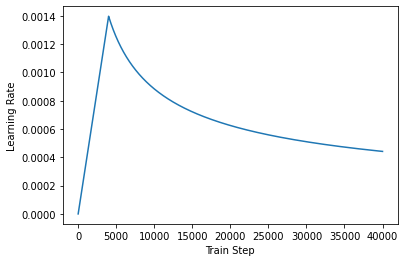

In [255]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [0]:
loss_obejct = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_obejct(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_  *= mask
  
  return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [0]:
train_loss = tf.keras.metrics.Mean(name='Train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='Train_Accuracy')

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, input_vocab_size, target_vocab_size, dropout_rate)

In [0]:
def create_mask(inp, tar):
  enc_padding_mask = create_padding_mask(inp)

  dec_padding_mask = create_padding_mask(tar)

  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask



In [0]:
check_point = './checkpoins/train'

ckpt = tf.train.Checkpoint(transfomer = transfomer, optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, check_point, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.resotre(ckpt_manager.latest_checkpoint)
  print('Latest Checkpoint Restored!')

In [0]:
train_step_signater = [tf.TensorSpec(shape = (None, None), dtype=tf.int64),
                       tf.TensorSpec(shape = (None, None), dtype=tf.int64)]

In [0]:
@tf.function
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _  = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)

    loss = loss_function(tar_real, predictions)

  gradients = tape.gradients(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [264]:
for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch+1) % 5 == 0:
      ckpt_save_path = ckpt_manager.save()
      print('Saving ckpt for epoch {} at {}'.format(epoch+1, ckpt_save_path))

  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))  

ValueError: ignored

# Checking

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [0]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [267]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [268]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [269]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [270]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [272]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [274]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [276]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [278]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [280]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [282]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [284]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [0]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

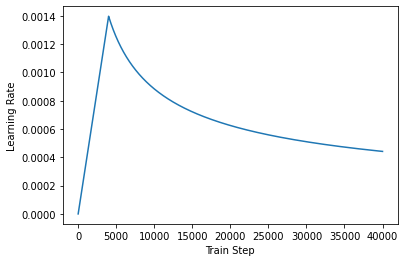

In [288]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [0]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [0]:
EPOCHS = 20

In [0]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

Portuguese is used as the input language and English is the target language.

In [297]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.9619 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9061 Accuracy 0.0049
Epoch 1 Batch 100 Loss 8.8226 Accuracy 0.0157
Epoch 1 Batch 150 Loss 8.7227 Accuracy 0.0194
Epoch 1 Batch 200 Loss 8.5961 Accuracy 0.0213
Epoch 1 Batch 250 Loss 8.4425 Accuracy 0.0225
Epoch 1 Batch 300 Loss 8.2656 Accuracy 0.0235
Epoch 1 Batch 350 Loss 8.0787 Accuracy 0.0272
Epoch 1 Batch 400 Loss 7.9007 Accuracy 0.0312
Epoch 1 Batch 450 Loss 7.7387 Accuracy 0.0345
Epoch 1 Batch 500 Loss 7.5960 Accuracy 0.0375
Epoch 1 Batch 550 Loss 7.4621 Accuracy 0.0411
Epoch 1 Batch 600 Loss 7.3359 Accuracy 0.0449
Epoch 1 Batch 650 Loss 7.2169 Accuracy 0.0485
Epoch 1 Batch 700 Loss 7.1018 Accuracy 0.0520
Epoch 1 Loss 7.0974 Accuracy 0.0521
Time taken for 1 epoch: 150.8231599330902 secs

Epoch 2 Batch 0 Loss 5.6398 Accuracy 0.1018
Epoch 2 Batch 50 Loss 5.4665 Accuracy 0.1032
Epoch 2 Batch 100 Loss 5.4098 Accuracy 0.1058
Epoch 2 Batch 150 Loss 5.3570 Accuracy 0.1080
Epoch 2 Batch 200 Loss 5.3064 Accuracy 0.1103
Ep

In [0]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size+1]

  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)

  decoder_input = [tokenizer_en.vocab_size] # sos
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

    predictions, attention_weights = transfomer(encoder_input, output, False, enc_padding_mask, combined_mask, dec_padding_mask)

    predictions = predictions[:, -1:, :]

    predictions_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    print(predictions_id)

    if predictions_id == tokenizer_en.vocab_size + 1:
      return tf.squeeze(output, axis=0), attention_weights
    
    output = tf.concat([output, predictions_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [304]:
evaluate('e quando melhoramos a procura')

tf.Tensor([[6513]], shape=(1, 1), dtype=int32)


(<tf.Tensor: shape=(2,), dtype=int32, numpy=array([8087, 6513], dtype=int32)>,
 {'decoder_layer1_block1': <tf.Tensor: shape=(1, 8, 1, 1), dtype=float32, numpy=
  array([[[[1.]],
  
          [[1.]],
  
          [[1.]],
  
          [[1.]],
  
          [[1.]],
  
          [[1.]],
  
          [[1.]],
  
          [[1.]]]], dtype=float32)>,
  'decoder_layer1_block2': <tf.Tensor: shape=(1, 8, 1, 8), dtype=float32, numpy=
  array([[[[0.12341358, 0.14171085, 0.13273488, 0.11244687, 0.11873712,
            0.11593676, 0.12598245, 0.12903745]],
  
          [[0.11478388, 0.11327739, 0.12973899, 0.134973  , 0.11143824,
            0.12816773, 0.12040751, 0.14721322]],
  
          [[0.11759933, 0.11360823, 0.10857452, 0.13752243, 0.11668846,
            0.14760564, 0.12725931, 0.13114208]],
  
          [[0.11356229, 0.10729198, 0.10343185, 0.09524784, 0.12601839,
            0.19813696, 0.1346061 , 0.12170455]],
  
          [[0.11346406, 0.14177814, 0.12365998, 0.11197163, 0.14405005,
   

In [0]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    # ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [0]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [310]:
transformer.summary()

Model: "transformer_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_26 (Encoder)         multiple                  1844736   
_________________________________________________________________
decoder_32 (Decoder)         multiple                  2093696   
_________________________________________________________________
dense_1443 (Dense)           multiple                  1043481   
Total params: 4,981,913
Trainable params: 4,981,913
Non-trainable params: 0
_________________________________________________________________


tf.Tensor([[739]], shape=(1, 1), dtype=int32)
Input: este é o primeiro livro que eu fiz.
Predicted translation: questions 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  if sys.path[0] == '':


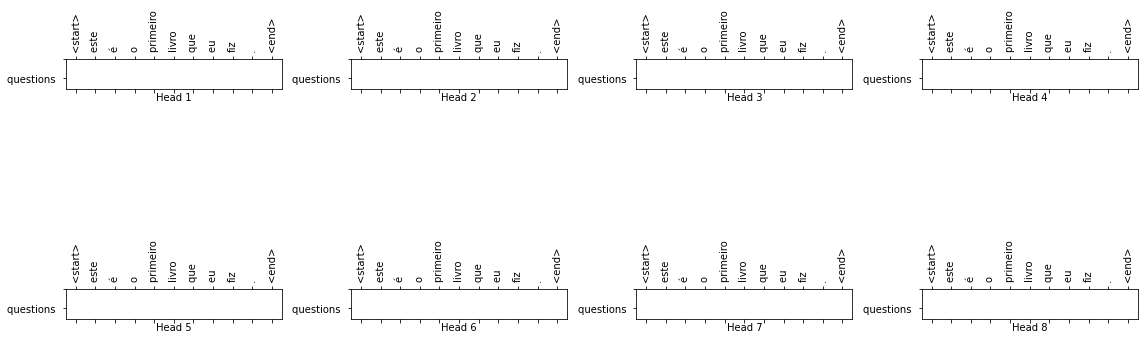

Real translation: this is the first book i've ever done.


In [321]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")